<p style="padding: 10px; border: 1px solid black;">
<img src="./utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>

# <a name="0">Multimodal Prediction using AutoGluon</a>

For problems on multimodal data tables that contain image, text, and tabular data, AutoGluon provides MultiModalPredictor (abbreviated as AutoMM) that automatically selects and fuses deep learning backbones from popular packages like [timm](https://github.com/rwightman/pytorch-image-models), [huggingface/transformers](https://github.com/huggingface/transformers), [CLIP](https://github.com/openai/CLIP), etc. 

You can use it to build models for multimodal problems that involve image, text, and tabular features, e.g., predicting the product price based on the items’ description, photo, and other metadata, or matching images with text descriptions.

In addition, being good at multimodal problems implies that the predictor will be good for each specific modality. Thus, you can also use AutoMM to solve standard NLP/Vision tasks like sentiment classification, intent detection, paraphrase detection, image classification. Moreover, AutoMM can be used as a basic model in the multi-layer stack-ensemble of TabularPredictor.

In the following, we prepared a few tutorials to help you learn how to use AutoMM to solve problems that involve image, text, and tabular data.

Note: Please use **GPU** for training. CPU training will lead to an unceasing running script. 
    
    
## <a href="#MultiModal-Predictor">Multimodal Predictor</a>
    
###  <a href="#AutoMM-for-Tabular-and-Text">AutoMM for Tabular and Text</a>

1. <a href="#Product-Similarity-Task">Product Similarity Task</a>
2. <a href="#Training-the-Predictor">Training the Predictor</a>   
3. <a href="#Model-Evaluation-and-Prediction"> Model Evaluation and Prediction  </a>
4. <a href="#Extract-Embeddings"> Extract Embeddings </a>
5. <a href="#What's-happening-inside?">What's happening inside?</a>
6. <a href="#How-does-this-compare-with-TabularPredictor?">How does this compare with TabularPredictor?</a>

    
###  <a href="#AutoMM-for-Tabular,-Text-and-Image">AutoMM for Tabular, Text and Image</a>
    
1. <a href="#Training-the-Predictor-with-Images-and-Text">Training the Predictor with Images and Text</a>   
2. <a href="#Model-Evaluation-and-Prediction-with-Full-Multimodal-Predictor">Model Evaluation and Prediction with Full Multimodal Predictor</a>
3. <a href="#Extract-Embeddings-using-Full-Multimodal-Predictor">Extract Embeddings using Full Multimodal Predictor</a>
4. <a href="#Save-and-Load-Full-Multimodal-Predictor">Save and Load Full Multimodal Predictor</a>
    
(<a href="#0">Go to top</a>)

Let's start by loading some libraries and packages!

In [1]:
# Install AutoGluon
# !pip install -q autogluon

In [2]:
%matplotlib inline

# Load in libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
np.random.seed(123)

# <a id="MultiModal-Predictor">MultiModal Predictor</a>

In this notebook, we will study AutoGluon's multimodal predictor on data which contains tabular, text as well as image data.

(<a href="#0">Go to top</a>)

# <a id="AutoMM-for-Tabular-and-Text">AutoMM for Tabular and Text</a>

In many applications, text data may be mixed with numeric/categorical data. 
AutoGluon's `AutoMMPredictor` can train a single neural network that jointly operates on multiple feature types, 
including text, categorical, and numerical columns. The general idea is to embed the text, categorical and numeric fields 
separately and fuse these features across modalities. This tutorial demonstrates such an application.

(<a href="#0">Go to top</a>)

## <a id="Product-Similarity-Task">Product Similarity Task</a>
Next, let's use AutoGluon to train a model for evaluating how similar two products are using the tabular and text features.

Let's load the dataset into dataframes. For model evaluation, let's further split the training dataset into a training set and a validation set.

(<a href="#0">Go to top</a>)

In [3]:
# Load the training dataset
df_train = pd.read_csv("../data/training.csv")

# Load the test dataset
df_test = pd.read_csv("../data/mlu-leaderboard-test.csv")


train_data, val_data = train_test_split(
    df_train[['item_name_1', 'item_name_2', 
              'product_type_1', 'product_type_2', 
              'product_description_1', 'product_description_2', 
              'item_package_quantity_1', 'item_package_quantity_2', 
              'label']],
    test_size=0.10,
    shuffle=True,
    random_state=324,
)

train_data.head()

,item_name_1,item_name_2,product_type_1,product_type_2,product_description_1,product_description_2,item_package_quantity_1,item_package_quantity_2,label
7199,Gem Stone King 10.00 Ct Round Cut Stunning Cub...,Gem Stone King 10.00 Ct Round Cut Stunning Cub...,FASHIONNECKLACEBRACELETANKLET,FASHIONNECKLACEBRACELETANKLET,This beautiful item is brand new and comes wit...,This beautiful item is brand new and comes wit...,1.0,1.0,0
18532,Orange Circle Studio 2019 Hidden Spiral Agenda...,Orange Circle Studio 2019 Hidden Spiral Agenda...,OFFICE_PRODUCTS,ABIS_BOOK,NaN,NaN,1.0,NaN,0
18501,"9"" x 100' Black EPDM 60 mil P & S CURED RUBBER...","FBA 9"" x 100' Black EPDM 60 mil P & S Cured Ru...",BUILDING_MATERIAL,BUILDING_MATERIAL,10 year FULL PRODUCT REPLACEMENT WARRANTY TECH...,10 year FULL PRODUCT REPLACEMENT WARRANTY TECH...,1.0,1.0,1
11334,"Frontier Bulk Lemon Peel Granules, ORGANIC, 1 ...","Frontier Bulk Bac'Uns Vegetarian Bits, ORGANIC...",GROCERY,WIRELESS_ACCESSORY,NaN,Ingredients Organic textured soy protein (orga...,2.0,2.0,0
13020,Blue Sea 7242 A-Series Double Pole Toggle - 50...,BLUE SEA SYSTEMS 7242 / Blue Sea 7242 A-Series...,MISC_OTHER,MONITOR,<b>A-Series Toggle Double Pole</b><br/><br/><b...,<b>A-Series Toggle Double Pole</b><br/><br/><b...,1.0,1.0,1


In this data, the column named label contains categorical/numerical values (which we'd like to predict) that are human-annotated similarity scores for each given pair of sentences.

In [4]:
print('Min score=', min(train_data['label']), ', Max score=', max(train_data['label']))

Min score= 0 , Max score= 1


Let's train a model to predict these labels. 
Note that we only need to specify the label column and AutoGluon automatically determines the type of prediction problem and an appropriate loss function. 
Once again, you should increase the short `time_limit` below to obtain reasonable performance in your own applications.

## <a id="Training-Predictor">Training the Predictor</a>


We can simply create a AutoMMPredictor and call `predictor.fit()` to train a model that operates on across all types of features. 
Internally, the neural network will be automatically generated based on the inferred data type of each feature column. 
To save time, we subsample the data and only train for three minutes.

(<a href="#0">Go to top</a>)

In [5]:
from autogluon.multimodal import AutoMMPredictor
time_limit = 10 * 60  # set to larger value in your applications
predictor = AutoMMPredictor(label='label', path='./AutogluonModels/MultiModalText')
predictor.fit(train_data, time_limit=time_limit)

Global seed set to 123
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                | Params
----------------------------------------------------------
0 | model             | MultimodalFusionMLP | 109 M 
1 | validation_metric | AUROC               | 0     
2 | loss_func         | CrossEntropyLoss    | 0     
----------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
219.567   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 59: 'val_roc_auc' reached 0.69161 (best 0.69161), saving model to '/home/ec2-user/SageMaker/notebooks/AutogluonModels/MultiModalText/epoch=0-step=59.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 119: 'val_roc_auc' reached 0.74657 (best 0.74657), saving model to '/home/ec2-user/SageMaker/notebooks/AutogluonModels/MultiModalText/epoch=0-step=119.ckpt' as top 3
Time limit reached. Elapsed time is 0:10:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 120: 'val_roc_auc' reached 0.73757 (best 0.74657), saving model to '/home/ec2-user/SageMaker/notebooks/AutogluonModels/MultiModalText/epoch=0-step=120.ckpt' as top 3
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

## <a id="Model-Evaluation-and-Prediction">Model Evaluation and Prediction</a>

We can easily obtain predictions and extract data embeddings using the AutoMMPredictor.

(<a href="#0">Go to top</a>)


We again evaluate our trained model's performance on separate validation data. Below we choose to compute the following metrics: RMSE, Pearson Correlation, and Spearman Correlation.


In [6]:
predictions = predictor.predict(val_data)
print('Predictions:')
print('------------')
print(np.exp(predictions) - 1)
print()
print('True Value:')
print('------------')
print(np.exp(val_data['label']) - 1)

Predicting: 0it [00:00, ?it/s]

Predictions:
------------
5572     0.000000
9085     0.000000
4228     0.000000
16907    0.000000
9019     0.000000
           ...   
16037    1.718282
6415     0.000000
10769    0.000000
14412    0.000000
11010    0.000000
Name: label, Length: 1890, dtype: float64

True Value:
------------
5572     1.718282
9085     1.718282
4228     0.000000
16907    0.000000
9019     1.718282
           ...   
16037    0.000000
6415     0.000000
10769    0.000000
14412    1.718282
11010    1.718282
Name: label, Length: 1890, dtype: float64


In [7]:
performance = predictor.evaluate(val_data)
print(performance)

Predicting: 0it [00:00, ?it/s]

{'roc_auc': 0.7396323712308953}


In [8]:
val_score = predictor.evaluate(val_data, metrics=['rmse', 'pearsonr', 'spearmanr'])
print('RMSE = {:.2f}'.format(val_score['rmse']))
print('PEARSONR = {:.4f}'.format(val_score['pearsonr']))
print('SPEARMANR = {:.4f}'.format(val_score['spearmanr']))

Predicting: 0it [00:00, ?it/s]

RMSE = 0.59
PEARSONR = 0.2762
SPEARMANR = 0.2762


In [9]:
predictor.evaluate(val_data, metrics=['acc', 'f1'])

Predicting: 0it [00:00, ?it/s]

{'acc': 0.6513227513227513, 'f1': 0.3481701285855589}

Let's use our model to predict the similarity score between two sentences.

## <a id="Extract-Embeddings">Extract Embeddings</a>
You can also use a trained predictor to extract embeddings that maps each row of the data table to an embedding vector extracted from intermediate neural network representations of the row.

(<a href="#0">Go to top</a>)

In [10]:
embeddings = predictor.extract_embedding(val_data)
print(embeddings.shape)

Predicting: 0it [00:00, ?it/s]

(1890, 128)


Here, we use TSNE to visualize these extracted embeddings. We can see that there are two clusters corresponding to our two labels, since this network has been trained to discriminate between these labels.

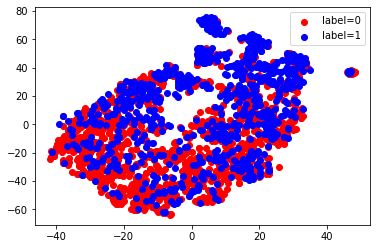

In [11]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=123).fit_transform(embeddings)
for val, color in [(0, 'red'), (1, 'blue')]:
    idx = (val_data['label'].to_numpy() == val).nonzero()
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
plt.legend(loc='best')

## <a id="What-is-happening">What's happening inside?</a>


Internally, we use different networks to encode the text columns, categorical columns, and numerical columns. The features generated by individual networks are aggregated by a late-fusion aggregator. The aggregator can output both the logits or score predictions. The architecture can be illustrated as follows:

![Multimodal Network with Late Fusion](https://autogluon-text-data.s3.amazonaws.com/figures/fuse-late.png)

:width:`600px`


Here, we use the pretrained NLP backbone to extract the text features and then use two other towers to extract the feature from categorical column and the numerical column.

In addition, to deal with multiple text fields, we separate these fields with the `[SEP]` token and alternate 0s and 1s as the segment IDs, which is shown as follows:

![Preprocessing](https://autogluon-text-data.s3.amazonaws.com/figures/preprocess.png)

:width:`600px`


## <a id="How-does-it-compare">How does this compare with TabularPredictor?</a>

Note that `TabularPredictor` can also handle data tables with text, numeric, and categorical columns, but it uses an ensemble of many types of models and may featurize text. `AutoMMPredictor` instead directly fuses multiple neural network models directly and handles 
raw text (which are also capable of handling additional numerical/categorical columns). We generally recommend `TabularPredictor` if your table contains mainly numeric/categorical columns and AutoMMPredictor if your table contains mainly text columns, 
but you may easily try both and we encourage this. In fact, `TabularPredictor.fit(..., hyperparameters='multimodal')` will train a AutoMMPredictor along with many other tabular models and ensemble them together. 
Refer to the tutorial "[tutorials/tabular_prediction/tabular-multimodal-text-others.ipynb](https://github.com/gidler/autogluon-tutorials/blob/main/tutorials/tabular_prediction/tabular-multimodal-text-others.ipynb)"  for more details.

## Other Examples

You may go to https://github.com/awslabs/autogluon/tree/master/examples/automm to explore other AutoMMPredictor examples.

## Customization
To customize AutoMM, please refer to [tutorials/multimodal/customization.ipynb](https://github.com/gidler/autogluon-tutorials/blob/main/tutorials/multimodal/customization.ipynb).

# <a id="AutoMM-for-Tabular,-Text-and-Image">AutoMM for Tabular, Text and Image</a>

AutoMM is a deep learning "model zoo" of model zoos. It can automatically build deep learning models that are suitable for multimodal datasets. You will only need to convert the data into the multimodal dataframe format and AutoMM can predict the values of one column conditioned on the features from the other columns including images, text, and tabular data.

Now let's introduce how to apply AutoGluon on Tabular, Text and Image data.

(<a href="#0">Go to top</a>)

In [41]:
df_train.head()

,list_price_value_1,product_type_1,item_name_1,product_description_1,bullet_point_1,brand_1,manufacturer_1,part_number_1,model_number_1,size_1,...,item_dimensions_width_2,item_dimensions_length_2,item_dimensions_height_2,list_price_currency_1,list_price_value_with_tax_1,list_price_currency_2,list_price_value_with_tax_2,imgID_1,imgID_2,ID
0,NaN,OFFICE_PRODUCTS,Charlyn Woodruff - CW Designs Monogram - Squar...,NaN,NaN,NaN,3dRose LLC,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41y91fNgZqL,510nboKsU5L,7dd5ed12f418440c9aa46813732ff7a3
1,NaN,HOBBIES,Propeller Guard Protector for DJI Mavic 2 Pro/...,Easy installation;Installing and removing the ...,Propeller Guard Protector for DJI Mavic 2 Pro/...,XSD MODEL,PGYTECH,681385399035,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41of5Aiv0jL,41of5Aiv0jL,7cbdc2cff2d44b15852302f15ac718dc
2,NaN,WIRELESS_ACCESSORY,Multi USB Charging Cable,0,0,MuchCORD,MuchCORD,NaN,NaN,4 Feet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41UwfSHCuEL,41UwfSHCuEL,fc50670a76ee4e25bf8fc56ce604877d
3,NaN,KITCHEN,Creative Converting Touch of Color 20 Count Pl...,NaN,10. 25-Inch premium plastic banquet plates in ...,Creative Converting,Creative Converting,28313131,28313131,One Size,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41gzBI7mLXL,41gzBI7mLXL,f11b496a223149aeb8c48d364940e64a
4,NaN,VIDEO_DVD,20th Century Fox Studio Classics (The Blue Max...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51b6p9J1AOL,51Ol7lW9VbL,afcc880457644c0d99fb3695ad062e47


In [42]:
df_test.head()

,list_price_value_1,product_type_1,item_name_1,product_description_1,bullet_point_1,brand_1,manufacturer_1,part_number_1,model_number_1,size_1,...,item_dimensions_width_2,item_dimensions_length_2,item_dimensions_height_2,list_price_currency_1,list_price_value_with_tax_1,list_price_currency_2,list_price_value_with_tax_2,imgID_1,imgID_2,ID
0,NaN,HEADPHONES,"Bluetooth Headphones, ESTAVEL Wireless Sports ...",The model number is HT-BT03<br><br><b>[Waterpr...,[SUPER QUALITY&AMAZING BASS]This sport wireles...,ESTAVEL,ESTAVEL,HT,NaN,Black,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41rS6EmkzTL,41wxxq7168L,d612d10afd8242c892ad2c697cc64cd8
1,NaN,SOUND_AND_RECORDING_EQUIPMENT,Rane TTM57 MKII Club/DJ Mixer W/Serato DJ+Dual...,The TTM57mkII stays true to its original desig...,Rane TTM57 MKII Club/DJ Mixer W/Serato DJ+Dire...,Rane,Rane,TTM57 MKII+BRLRMXBP1+RED WAVE+ATM510,TTM57 MKII+BRLRMXBP1+RED WAVE+ATM510,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,510Tc3DmEBL,51qWaOS8ytL,faf5a521ca994cc889d6db29ecdb82e0
2,NaN,STICKER_DECAL,Cartoon Sticker '' Sesame Street Elmo Cartoon '',-Gently peel off the sticker by nail tip.\n-Cl...,"Decorate photo albums, notebooks,moblie, car,m...",Hometown,Sticker,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51rWGz3k8OL,51rWGz3k8OL,0a873fd0823b4e6da423aedfb3119de9
3,NaN,AUTO_PART,XENON HALOGEN FOG LIGHTS For 05-10 NISSAN NAVA...,This auction includes a complete fog lamp kit ...,(2) 55 Watt 4100K Xenon Halogen Lamps,BlingLights,NaN,bl-300w-d4-navara,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41SuFxTWs2L,41SuFxTWs2L,cadf42deef854462b1f9adcb2ab8ce2b
4,NaN,PERSONAL_CARE_APPLIANCE,"Little Sunny 7.6Inch Premium Dildo, Classical ...",<BR>Product Description: <BR>All dildo cock fr...,"Made of 100% pure liquid silicone, safe ,odorl...",Little Sunny,Little Sunny,AAC570717022,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41DUNzQGZqL,41DUNzQGZqL,278dfd58a7c8412aa7e2b3c5bc21438c


In [43]:
label_col = 'label'

In [44]:
image_path = '../data/images/'
image_col1 = 'imgID_1'
image_col2 = 'imgID_2'


In [45]:
def path_expander(path, base_folder):
    path = path +'.jpg'
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])



We need to expand the image paths to load them in training.


In [46]:
df_train[image_col1] = df_train[image_col1].apply(lambda ele: path_expander(ele, base_folder=image_path))
df_test[image_col1] = df_test[image_col1].apply(lambda ele: path_expander(ele, base_folder=image_path))

df_train[image_col1].iloc[0]

'/home/ec2-user/SageMaker/data/images/41y91fNgZqL.jpg'

In [47]:
df_train[image_col2] = df_train[image_col2].apply(lambda ele: path_expander(ele, base_folder=image_path))
df_test[image_col2] = df_test[image_col2].apply(lambda ele: path_expander(ele, base_folder=image_path))

df_train[image_col2].iloc[0]

'/home/ec2-user/SageMaker/data/images/510nboKsU5L.jpg'

Each row includes a pair of item names, image IDs, product description, and various tabular features such as item package quantity, list price value, and product weight. 
Let's look at an example row of data and display the text description and a picture.

In [48]:
example_row = df_train.iloc[0]
example_row

list_price_value_1                                                           NaN
product_type_1                                                   OFFICE_PRODUCTS
item_name_1                    Charlyn Woodruff - CW Designs Monogram - Squar...
product_description_1                                                        NaN
bullet_point_1                                                               NaN
                                                     ...                        
list_price_currency_2                                                        NaN
list_price_value_with_tax_2                                                  NaN
imgID_1                        /home/ec2-user/SageMaker/data/images/41y91fNgZ...
imgID_2                        /home/ec2-user/SageMaker/data/images/510nboKsU...
ID                                              7dd5ed12f418440c9aa46813732ff7a3
Name: 0, Length: 64, dtype: object

In [49]:
example_row['item_name_1']

'Charlyn Woodruff - CW Designs Monogram - Squares - Modern Geometric Black Red Grey Square Pattern Monogram Letter A - MousePad (mp_215218_1)'

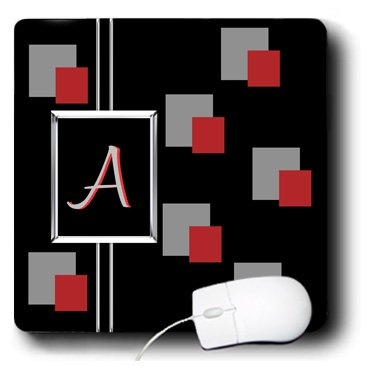

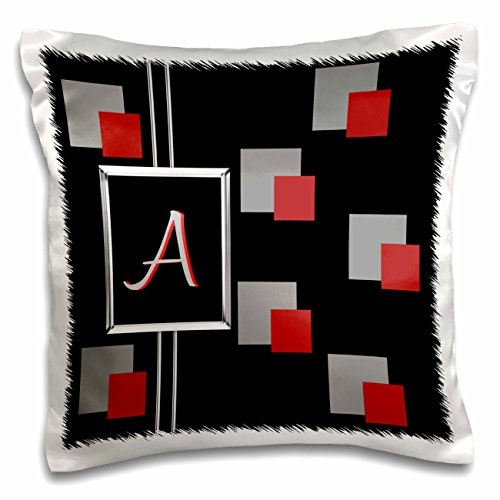

In [50]:
example_image1 = example_row[image_col1]
example_image2 = example_row[image_col2]

from IPython.display import Image, display
pil_img1 = Image(filename=example_image1)
display(pil_img1)
pil_img2 = Image(filename=example_image2)
display(pil_img2)

In [51]:
train_data, val_data = train_test_split(
    df_train[['item_name_1', 'item_name_2', 
              'item_package_quantity_1', 'item_package_quantity_2', 
              'imgID_1', 'imgID_2',
              'label']],
    test_size=0.10,
    shuffle=True,
    random_state=324,
)

train_data.head()

,item_name_1,item_name_2,item_package_quantity_1,item_package_quantity_2,imgID_1,imgID_2,label
7199,Gem Stone King 10.00 Ct Round Cut Stunning Cub...,Gem Stone King 10.00 Ct Round Cut Stunning Cub...,1.0,1.0,/home/ec2-user/SageMaker/data/images/41kUCrQrT...,/home/ec2-user/SageMaker/data/images/41kUCrQrT...,0
18532,Orange Circle Studio 2019 Hidden Spiral Agenda...,Orange Circle Studio 2019 Hidden Spiral Agenda...,1.0,NaN,/home/ec2-user/SageMaker/data/images/51ud799kH...,/home/ec2-user/SageMaker/data/images/61+Y5aPcf...,0
18501,"9"" x 100' Black EPDM 60 mil P & S CURED RUBBER...","FBA 9"" x 100' Black EPDM 60 mil P & S Cured Ru...",1.0,1.0,/home/ec2-user/SageMaker/data/images/51xNNSO78...,/home/ec2-user/SageMaker/data/images/51xNNSO78...,1
11334,"Frontier Bulk Lemon Peel Granules, ORGANIC, 1 ...","Frontier Bulk Bac'Uns Vegetarian Bits, ORGANIC...",2.0,2.0,/home/ec2-user/SageMaker/data/images/31wD2KS80...,/home/ec2-user/SageMaker/data/images/31wD2KS80...,0
13020,Blue Sea 7242 A-Series Double Pole Toggle - 50...,BLUE SEA SYSTEMS 7242 / Blue Sea 7242 A-Series...,1.0,1.0,/home/ec2-user/SageMaker/data/images/51Opc1sQW...,/home/ec2-user/SageMaker/data/images/51Opc1sQW...,1


## <a id="Training-the-Predictor-with-Images-and-Text">Training the Predictor with Images and Text</a> 
Now let's fit the predictor with the training data. Here we set a tight time budget for a quick demo.

(<a href="#0">Go to top</a>)

In [27]:
from autogluon.multimodal import AutoMMPredictor
predictor = AutoMMPredictor(label=label_col)
predictor.fit(
    train_data=train_data,
    time_limit=120, # seconds
)

Global seed set to 123
Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                | Params
----------------------------------------------------------
0 | model             | MultimodalFusionMLP | 109 M 
1 | validation_metric | AUROC               | 0     
2 | loss_func         | CrossEntropyLoss    | 0     
----------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
219.567   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 59: 'val_roc_auc' reached 0.75263 (best 0.75263), saving model to '/home/ec2-user/SageMaker/notebooks/AutogluonModels/ag-20220810_015103/epoch=0-step=59.ckpt' as top 3
Time limit reached. Elapsed time is 0:02:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 80: 'val_roc_auc' reached 0.78863 (best 0.78863), saving model to '/home/ec2-user/SageMaker/notebooks/AutogluonModels/ag-20220810_015103/epoch=0-step=80.ckpt' as top 3
Start to fuse 2 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Under the hood, AutoMM automatically infers the problem type (classification or regression), detects the data modalities, selects the related models from the multimodal model pools, and trains the selected models. If multiple backbones are available, AutoMM appends a late-fusion model (MLP or transformer) on top of them.

## <a id="Model-Evaluation-and-Prediction-with-Full-Multimodal-Predictor">Model Evaluation and Prediction with Full Multimodal Predictor</a>
Then we can evaluate the predictor on the validation data.

(<a href="#0">Go to top</a>)

In [28]:
scores = predictor.evaluate(val_data, metrics=["roc_auc"])
scores

Predicting: 0it [00:00, ?it/s]

{'roc_auc': 0.7768161487650512}

In [29]:
test_data = df_test[['item_name_1', 'item_name_2', 
              'item_package_quantity_1', 'item_package_quantity_2', 
              'imgID_1', 'imgID_2']]

### Prediction
Given a multimodal dataframe without the label column, we can predict the labels.

In [30]:
predictions = predictor.predict(test_data)
predictions[:5]

Predicting: 0it [00:00, ?it/s]

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

For classification tasks, we can get the probabilities of all classes.

In [31]:
probas = predictor.predict_proba(test_data)
probas[:5]

Predicting: 0it [00:00, ?it/s]

,0,1
0,0.615319,0.384681
1,0.723041,0.276959
2,0.536981,0.463019
3,0.648911,0.351089
4,0.684633,0.315367


Note that calling `.predict_proba()` on one regression task will throw an exception.

### Prediction on the test data

In [32]:
test_predictions = predictor.predict(df_test[['item_name_1', 'item_name_2', 
              'item_package_quantity_1', 'item_package_quantity_2', 
              'imgID_1', 'imgID_2']])
test_predictions.head()

Predicting: 0it [00:00, ?it/s]

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

## <a id="Extract-Embeddings-using-Full-Multimodal-Predictor">Extract Embeddings using Full Multimodal Predictor</a>

Extracting embeddings can also be useful in many cases, where we want to convert each sample (per row in the dataframe) into an embedding vector.

(<a href="#0">Go to top</a>)

In [33]:
embeddings = predictor.extract_embedding(test_data)
embeddings.shape

Predicting: 0it [00:00, ?it/s]

(1000, 128)

## <a id="Save-and-Load-Full-Multimodal-Predictor">Save and Load Full Multimodal Predictor</a>

It is also convenient to save a predictor and re-load it.

(<a href="#0">Go to top</a>)

In [35]:
predictor.save('AutogluonModels/MultiModalAll/AutoMMPredictor.ag')


In [36]:
loaded_predictor = AutoMMPredictor.load('./AutogluonModels/MultiModalAll/AutoMMPredictor.ag')
scores2 = loaded_predictor.evaluate(val_data, metrics=["roc_auc"])
scores2

Load pretrained checkpoint: ./AutogluonModels/MultiModalAll/AutoMMPredictor.ag/model.ckpt


Predicting: 0it [00:00, ?it/s]

{'roc_auc': 0.7768161487650512}

In [37]:
#!rm -r AutogluonModels

<p style="padding: 10px; border: 1px solid black;">
<img src="./utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>

# Thank you!